In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn import model_selection
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import  confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# Data Loading

In [2]:
df = pd.read_csv(r"C:\Users\user\Documents\UoM\8th_semester\Neural Neworks\2η εργασία\log2.csv", engine="python")

# Data Exploration

In [3]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [4]:
df.isnull().any()

Source Port             False
Destination Port        False
NAT Source Port         False
NAT Destination Port    False
Action                  False
Bytes                   False
Bytes Sent              False
Bytes Received          False
Packets                 False
Elapsed Time (sec)      False
pkts_sent               False
pkts_received           False
dtype: bool

In [5]:
df['Action'].value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

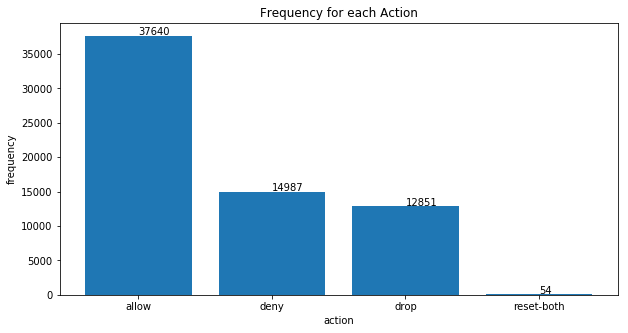

In [6]:
class_labels = ['allow', 'deny', 'drop', 'reset-both']
class_count = list(df['Action'].value_counts())

plt.figure(figsize=(10,5))
plt.bar(class_labels, class_count)
plt.title('Frequency for each Action')
plt.xlabel('action')
plt.ylabel('frequency')
for i, v in enumerate(class_count):
    plt.text(i, v + 100, s = str(v))
plt.show()

# Data Preprocessing

In [7]:
df['target'] = df['Action']
df['target'] = df['target'].astype(str)
df = df.drop(['Action'], axis=1)

X = df.drop(['target'], axis=1).to_numpy()
y = df['target'].astype(str)

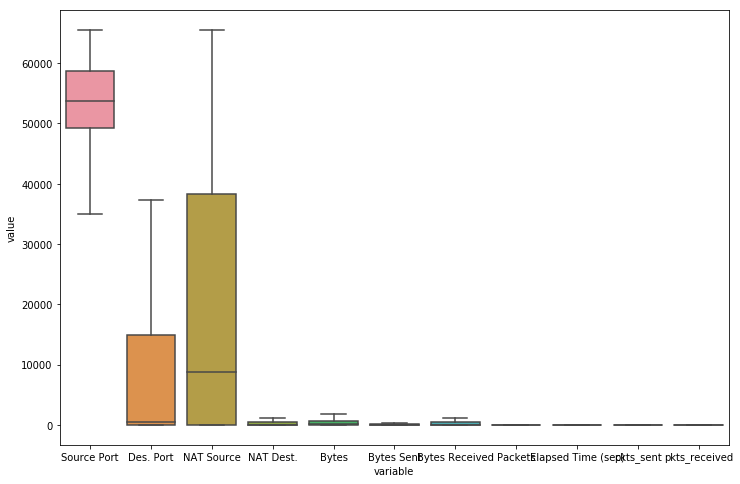

In [8]:
dataframe = pd.DataFrame(data=X, columns=['Source Port', 'Des. Port', 'NAT Source', 'NAT Dest.', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received'])
plt.figure(figsize=(12,8))
g = sns.boxplot(x="variable", y="value", data=pd.melt(dataframe), showfliers=False)
plt.show()

In [9]:
labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(y)

standardScaler = StandardScaler()
X = standardScaler.fit_transform(X)

# Apply oversampling because of the imbalanced dataset
oversampling = SMOTE(random_state=100)
X_Smote, Y_Smote = oversampling.fit_resample(X, y)

In [10]:
# split data to train and test
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(X_Smote, Y_Smote, test_size=0.3)

# Convert target variable to categorical, to train it to the neural network
Train_Y = to_categorical(Train_Y)
print(Train_Y)
Test_Y = to_categorical(Test_Y)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


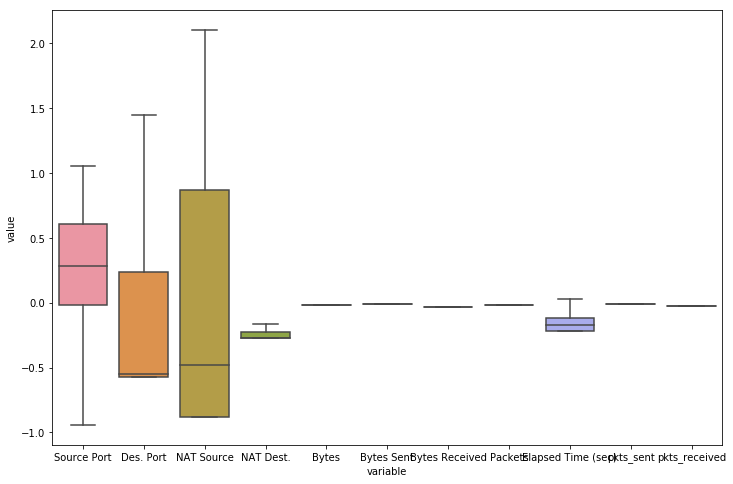

In [11]:
dataframe = pd.DataFrame(data=X, columns=['Source Port', 'Des. Port', 'NAT Source', 'NAT Dest.', 'Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received'])
plt.figure(figsize=(12,8))
g = sns.boxplot(x="variable", y="value", data=pd.melt(dataframe), showfliers=False)
plt.show()

# Build Neural Network Model

In [12]:
model = Sequential()

model.add(Dense(64, activation="relu", input_dim=11))
model.add(Dropout(0.1))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(4, activation="softmax"))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1

# Train Model

In [13]:
history = model.fit(Train_X, Train_Y, batch_size = 32, epochs = 100, validation_split=0.3)

Epoch 1/100
2306/2306 [==============================] - 7s 3ms/step - loss: 0.6141 - accuracy: 0.7235 - val_loss: 0.3025 - val_accuracy: 0.8426
Epoch 2/100
2306/2306 [==============================] - 5s 2ms/step - loss: 0.3339 - accuracy: 0.8381 - val_loss: 0.2912 - val_accuracy: 0.8621
Epoch 3/100
2306/2306 [==============================] - 5s 2ms/step - loss: 0.3159 - accuracy: 0.8522 - val_loss: 0.2691 - val_accuracy: 0.8864
Epoch 4/100
2306/2306 [==============================] - 5s 2ms/step - loss: 0.2946 - accuracy: 0.8675 - val_loss: 0.2319 - val_accuracy: 0.9059
Epoch 5/100
2306/2306 [==============================] - 5s 2ms/step - loss: 0.2688 - accuracy: 0.8882 - val_loss: 0.2288 - val_accuracy: 0.9027
Epoch 6/100
2306/2306 [==============================] - 5s 2ms/step - loss: 0.2579 - accuracy: 0.8936 - val_loss: 0.2131 - val_accuracy: 0.9141
Epoch 7/100
2306/2306 [==============================] - 5s 2ms/step - loss: 0.2478 - accuracy: 0.8972 - val_loss: 0.2042 - val_ac

2306/2306 [==============================] - 6s 3ms/step - loss: 0.1788 - accuracy: 0.9323 - val_loss: 0.1461 - val_accuracy: 0.9423
Epoch 58/100
2306/2306 [==============================] - 5s 2ms/step - loss: 0.1726 - accuracy: 0.9329 - val_loss: 0.1467 - val_accuracy: 0.9454
Epoch 59/100
2306/2306 [==============================] - 7s 3ms/step - loss: 0.1720 - accuracy: 0.9350 - val_loss: 0.1400 - val_accuracy: 0.9460
Epoch 60/100
2306/2306 [==============================] - 6s 3ms/step - loss: 0.1737 - accuracy: 0.9359 - val_loss: 0.1532 - val_accuracy: 0.9453
Epoch 61/100
2306/2306 [==============================] - 6s 2ms/step - loss: 0.1729 - accuracy: 0.9342 - val_loss: 0.1579 - val_accuracy: 0.9386
Epoch 62/100
2306/2306 [==============================] - 6s 3ms/step - loss: 0.1856 - accuracy: 0.9321 - val_loss: 0.1633 - val_accuracy: 0.9381
Epoch 63/100
2306/2306 [==============================] - 6s 2ms/step - loss: 0.1739 - accuracy: 0.9339 - val_loss: 0.1649 - val_accuracy

# Evaluate model

In [14]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 93.64%


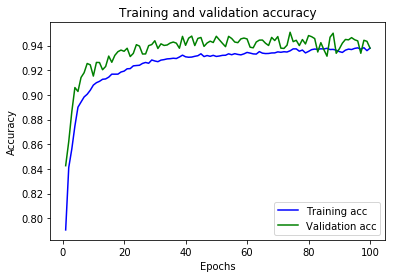

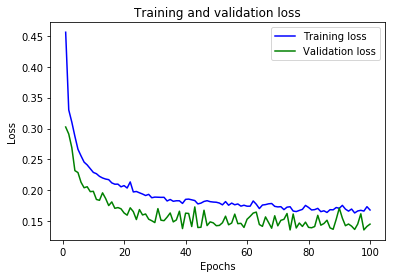

In [15]:
# Plotting Results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.jpeg')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [16]:
score = model.evaluate(Test_X, Test_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14467237889766693
Test accuracy: 0.9386069774627686


# Evaluate model on Test Data

In [24]:
Y_pred = model.predict(Test_X)

predicted_classes = []
for array in Y_pred:
    max_class = np.argmax(array)
    predicted_classes.append(max_class)
    
actual_classes = []
for array in Test_Y:
    max_class = np.argmax(array)
    actual_classes.append(max_class)

report = classification_report(actual_classes, predicted_classes, target_names=['allow','deny', 'drop', 'reset-both'], digits = 4)
cm = confusion_matrix(actual_classes, predicted_classes)



In [26]:
print(report)
print(cm)

              precision    recall  f1-score   support

       allow     0.9993    0.9972    0.9983     11182
        deny     0.9253    0.8229    0.8711     11379
        drop     0.9912    1.0000    0.9956     11189
  reset-both     0.8484    0.9363    0.8902     11418

    accuracy                         0.9386     45168
   macro avg     0.9411    0.9391    0.9388     45168
weighted avg     0.9405    0.9386    0.9383     45168

[[11151    29     0     2]
 [    8  9364    99  1908]
 [    0     0 11189     0]
 [    0   727     0 10691]]


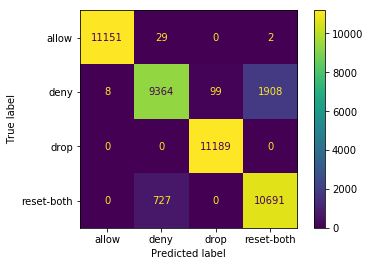

In [27]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['allow','deny', 'drop', 'reset-both'])
cmd.plot()

# Evaluate model on all data of the dataset

In [28]:
Y = model.predict(X)

predicted_classes = []
for array in Y:
    max_class = np.argmax(array)
    predicted_classes.append(max_class)
    
actual_classes = []
for item in y:
    actual_classes.append(item)

report = classification_report(y, predicted_classes, target_names=['allow','deny', 'drop', 'reset-both'], digits = 4) 
cm = confusion_matrix(y, predicted_classes)

In [29]:
print(report)
print(cm)

              precision    recall  f1-score   support

       allow     0.9998    0.9970    0.9984     37640
        deny     0.9913    0.8206    0.8979     14987
        drop     0.9901    1.0000    0.9950     12851
  reset-both     0.0188    0.9074    0.0368        54

    accuracy                         0.9572     65532
   macro avg     0.7500    0.9313    0.7320     65532
weighted avg     0.9951    0.9572    0.9740     65532

[[37528   103     1     8]
 [    9 12298   127  2553]
 [    0     0 12851     0]
 [    0     5     0    49]]


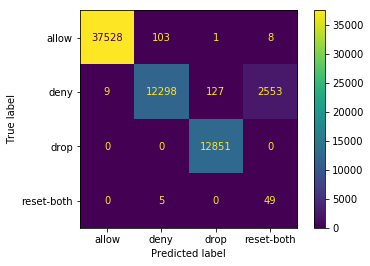

In [30]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['allow','deny', 'drop', 'reset-both'])
cmd.plot()

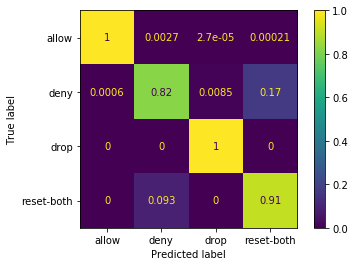

In [31]:
normalized_cm = confusion_matrix(y, predicted_classes, normalize='true')
normalized_cmd = ConfusionMatrixDisplay(normalized_cm, display_labels=['allow','deny', 'drop', 'reset-both'])
normalized_cmd .plot()